In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors

Basic test on CH-npt

In [3]:
# import data
CH_data = pd.read_table(r"data/result-CH-npt.txt", delim_whitespace=True)

In [8]:
CH_data['P(bar)'].describe()

count    181098.000000
mean        378.672962
std         355.270199
min           1.000000
25%          50.000000
50%         250.000000
75%         750.000000
max        1000.000000
Name: P(bar), dtype: float64

In [3]:
CH_data.sample(10,random_state=233)

,SMILES,T(K),P(bar),density(g/mL),einter(kJ/mol),cp(J/mol.K),raw_density(g/mL),raw_einter(kJ/mol)
46040,Cc1cc(C)c(cc1C)C,400,750,0.8544,-49.39,280.5,0.8549,-49.41
108061,CC(CCC(C1CCCCC1)(C)C)C,425,1000,0.8113,-59.88,474.1,0.8106,-59.80
138068,CC(C#C)CC,323,1,0.6803,-29.89,187.1,0.6797,-29.89
31293,CCC(CC(C(CC)C)(C)C)C,247,1,0.8042,-56.43,312.2,0.8049,-56.60
63494,C=CC(C)(C)C,212,50,0.7491,-31.36,159.6,0.7485,-31.32
96395,C1CC2C(C1)C1CCCC1CC2,614,750,0.7867,-43.54,452.9,0.7870,-43.53
81549,CCCCCCCCCCCCCC(=C)C,335,50,0.7674,-76.72,497.5,0.7667,-76.66
45983,Cc1cc(C)c(c(c1)C)C,543,500,0.7518,-41.20,337.0,0.7505,-41.10
120834,CCC1=CCCCCCC1,508,250,0.7169,-38.70,362.8,0.7167,-38.69
12814,CCCCC(CCCC)(C)C,314,50,0.7394,-49.81,340.0,0.7406,-49.91


In [4]:
class MolGraph():
    ''' OOP for cleaner programming, basically MCI calculation'''
    def __init__(self, SMILES):
        self.smiles = SMILES
        self.rdkmol = Chem.MolFromSmiles(SMILES)
        nonHatoms_n = len([1 for i in self.rdkmol.GetAtoms() if i.GetAtomicNum() != 1])
        # create adjacent matrix
        self.atomDeltaValence = np.zeros([nonHatoms_n])
        # self.atomDelta = np.array([i.GetExplicitValence() for i in self.rdkmol.GetAtoms()])
        self.adjMat = np.zeros([nonHatoms_n, nonHatoms_n], dtype=np.int64)
        bonds_n = len(self.rdkmol.GetBonds())
        self.bondDeltaValence = np.zeros([bonds_n])
        for idx, bond in enumerate(self.rdkmol.GetBonds()):
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            self.adjMat[i][j] = 1
            self.adjMat[j][i] = 1
        self.atomDelta = self.adjMat.sum(axis=1)
        self.bondDelta = np.zeros([bonds_n])
        self.translate()
        self.MCI()
        self.check()
    def translate(self):
        ''' calculate delta for further calculation '''
        idx = 0
        # delta atom
        for i in self.rdkmol.GetAtoms():
            if i.GetAtomicNum() == 1:
                continue
            self.atomDeltaValence[idx] = (i.GetTotalValence()-i.GetTotalNumHs()/(i.GetAtomicNum() - i.GetTotalValence() - 1))
            idx += 1
        # delta valence
        for idx, bond in enumerate(self.rdkmol.GetBonds()):
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            self.bondDeltaValence[idx] = self.atomDeltaValence[i]*self.atomDeltaValence[j]
            self.bondDelta[idx] = self.atomDelta[i] * self.atomDelta[j]
            '''
            # creating atomic fingerprint for further indexing
            AtomicNum = i.GetAtomicNum()
            TotalNumH = i.GetTotalNumHs()
            DOUBLE = Chem.rdchem.BondType.DOUBLE
            TRIPLE = Chem.rdchem.BondType.TRIPLE
            DoubleBond_n = len(list(filter(lambda x: x.GetBondType() == DOUBLE, a.GetBonds())))
            TripleBond_n = len(list(filter(lambda x: x.GetBondType() == TRIPLE, a.GetBonds())))
            atom_env = (AtomicNum, TotalNumH, DOUBLE, TRIPLE)
            self.atomDelta[idx] = MCI_dict[atom_env]
            '''
    def check(self):
        for i in self.atomDeltaValence:
            if abs(i) < 1e-08 :
                print('Warning in ' + self.SMILES)
            return self
        for i in self.atomDelta:
            if abs(i) < 1e-08 :
                print('Warning in ' + self.SMILES)
            return self
        for i in self.bondDeltaValence:
            if abs(i) < 1e-08 :
                print('Warning in ' + self.SMILES)
            return self
        for i in self.atomDeltaValence:
            if abs(i) < 1e-08 :
                print('Warning in ' + self.SMILES)
            return self
    def MCI(self):
        '''calculate the zero and first order MCI/valence-MCI '''
        self.vMCI0 = sum(self.atomDeltaValence ** (-0.5) ) 
        self.MCI0 = sum(self.atomDelta ** (-0.5) ) 
        self.MCI1 = sum(self.bondDelta **(-0.5) )
        self.vMCI1 = sum(self.bondDeltaValence ** (-0.5) )
    def getMCI(self):
        return self.MCI0, self.MCI1, self.vMCI0, self.vMCI1

In [88]:
rdkmol = Chem.MolFromSmiles('C=CC(C)(C)C')

In [93]:
x = MolGraph('C=CC(C)(C)C')

In [94]:
x.getMCI()

(5.207106781186548, 2.5606601717798214, 4.784457050376173, 2.1969234250586758)

In [71]:
x.atomDelta ** (-0.5)

array([0.70710678, 0.57735027, 0.5       , 1.        , 1.        ,
       1.        ])

In [49]:
DOUBLE = Chem.rdchem.BondType.DOUBLE
TRIPLE = Chem.rdchem.BondType.TRIPLE

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
import os
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

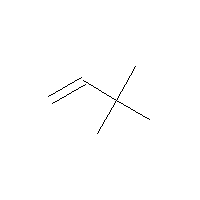

In [21]:
Draw.MolsToImage([rdkmol]) 

In [5]:
CH_data_TP = CH_data[ (CH_data['T(K)']==650) & (CH_data['P(bar)']==1) ]

In [6]:
MCIs = np.array([MolGraph(i).getMCI() for i in CH_data_TP['SMILES']])

In [122]:
for i in CH_data_TP['SMILES']:
    print(i)

C1CCCCC(C1)C1CCCCCC1
C1CCC2C(C1)CC1C(C2)CCCC1
C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1
C1CC[C@@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2
C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@H](C2)CCCC1
C1CC[C@@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1
C1CC[C@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2
C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@H]1CC2
C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@@H]1CC2
C1CCC(C1)C1CCC(C1)C1CCCC1
C1CCCCCC(C1)C1CCCCCCC1
C1CCCCCC2CCC(CCCC1)CC2
C1CCC2C(C1)C1CC3C(C1C2)CCCC3
C1CCC(C1)C(C1CCCC1)C1CCCC1
CC1CCCC2C1C1C(C)CCCC1CC2
CC1(C)CCCC2C1CCC1C2CCCC1
C1CCC(CC1)C1(CCCCC1)C1CCCC1
CCC1(CCCCC1)CC1(CC)CCCCC1
CCCCC(C1CCCC2C1CCCC2)(C)C
CCC1C(CC)C(CC)C(C(C1CC)CC)CC
CC1(CC(C2C1CCCC2)(C)C)C1CCCCC1
CCCCCCC1C(CCCC)CC2C1CCCC2
c1ccc2c(cc1)ccc2
C1=CC=C2C(=CC=CC=C2)C=C1
c1ccc2c(c1)Cc1c2cccc1
C1CCC(CC1)Cc1ccccc1
C1CCC2=C(C1)Cc1c2cccc1
C1=CCC2C(C1)Cc1c2cccc1
C1CCC2C(C1)Cc1c2cccc1
CC1=C(C)c2c(CC1)c(C)ccc2
Cc1ccc(cc1)C1=CCCCC1
CC(C1CCCc2c1cccc2)C
Cc1cccc2c1Cc1c2cccc1
C1CCC(CC1)C=Cc1ccccc1
c1ccc(cc1)C=Cc1ccccc1
c1ccc(cc1)C#Cc1ccccc1
C=C(c

In [7]:
CH_data_TP.loc[:,'MCI0'],CH_data_TP.loc[:,'MCI1'], CH_data_TP.loc[:,'vMCI0'], CH_data_TP.loc[:,'vMCI1'] = MCIs[:,0],  MCIs[:,1],  MCIs[:,2],  MCIs[:,3]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
CH_data_TP['density(g/mol)'] = Descriptors.MolWt(Chem.MolFromSmiles(CH_data_TP['SMILES'])) / CH_data_TP['density(g/mL)']

TypeError: No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type Series

In [12]:
Vm = np.array([Descriptors.MolWt(Chem.MolFromSmiles(i)) / j for i,j in zip(CH_data_TP['SMILES'], CH_data_TP['density(g/mL)']) ])

In [14]:
CH_data_TP['Vm(mL/mol)'] = Vm

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
CH_data_TP

,SMILES,T(K),P(bar),density(g/mL),einter(kJ/mol),cp(J/mol.K),raw_density(g/mL),raw_einter(kJ/mol),MCI0,MCI1,vMCI0,vMCI1,Vm(mL/mol)
106013,C1CCCCC(C1)C1CCCCCC1,650,1,0.6232,-39.82,617.300000,0.6190,-39.47,9.639982,6.966326,9.639982,6.966326,311.877407
106293,C1CCC2C(C1)CC1C(C2)CCCC1,650,1,0.6540,-39.76,583.700000,0.6527,-39.56,9.380469,6.932653,9.380469,6.932653,294.107034
106626,C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1,650,1,0.6659,-39.11,579.000000,0.6626,-38.89,9.380469,6.932653,9.380469,6.932653,288.851179
108185,C1CC[C@@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2,650,1,0.6657,-39.89,578.700000,0.6629,-39.74,9.380469,6.949490,9.380469,6.949490,288.937960
108855,C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@H](C2)CCCC1,650,1,0.6626,-38.89,585.300000,0.6599,-38.66,9.380469,6.932653,9.380469,6.932653,290.289768
108910,C1CC[C@@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1,650,1,0.6563,-39.00,590.000000,0.6507,-38.61,9.380469,6.932653,9.380469,6.932653,293.076337
109022,C1CC[C@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2,650,1,0.6665,-39.48,579.400000,0.6653,-39.42,9.380469,6.949490,9.380469,6.949490,288.591148
109078,C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@H]1CC2,650,1,0.6619,-38.77,585.300000,0.6583,-38.58,9.380469,6.949490,9.380469,6.949490,290.596767
109134,C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@@H]1CC2,650,1,0.6612,-38.66,586.900000,0.6565,-38.39,9.380469,6.949490,9.380469,6.949490,290.904416
110307,C1CCC(C1)C1CCC(C1)C1CCCC1,650,1,0.6518,-44.93,631.600000,0.6496,-44.75,10.087576,7.432653,10.087576,7.432653,316.620129


In [16]:
raw_data = CH_data_TP

In [11]:
pd.set_option('display.max_rows', None)
print(CH_data.groupby(['T(K)','P(bar)'])['density(g/mL)'].count())

T(K)  P(bar)
113   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
121   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
130   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
133   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
135   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
137   1           1
      50          1
      100         1
      250         1
      500         1
      750         1
      1000        1
138   1           2
      50          2
      100         2
      250         2
      500         2
      750         2
      1000        2
141   1

In [268]:
data_all = pd.read_csv(r"data/result-CH-npt-MCI.csv")

In [289]:
data = data_all[ (data_all['T(K)']==472) & (data_all['P(bar)']==1) ].sample(frac=1)

In [293]:
MCIs = np.array(data.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1')])
#size = len(MCIs)
size = 80
ratio = 0.7
X_train = MCIs[:int(size*0.7)]#[:,(0,3)]
X_test = MCIs[-int(size*0.3):]#[:,(0,3)]
y_train =  data['Vm(mL/mol)'][:int(size*0.7)]
y_test =  data['Vm(mL/mol)'][-int(size*0.3):]

reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
y_pred = reg.predict(X_test)

0.9365412490514486
0.9068981947183128


Text(0,0.5,'predict(mL/mol)')

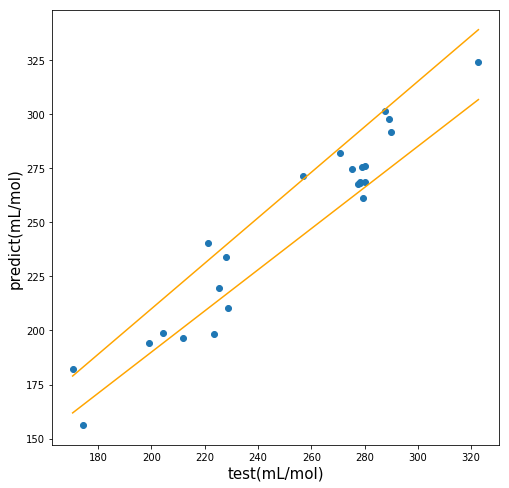

In [294]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
ymin, ymax = min(y_test), max(y_test)
plt.plot([ymin,ymax], [ymin*1.05, ymax*1.05],color='orange')
plt.plot([ymin,ymax], [ymin*0.95, ymax*0.95],color='orange')
plt.xlabel('test(mL/mol)',size=15)
plt.ylabel('predict(mL/mol)',size=15)

In [287]:
((y_pred - y_test)*(y_pred - y_test)).mean()**0.5 / y_test.std()

0.2562467670022192

In [288]:
(abs(y_pred - y_test)/y_test).mean()

0.0341731894178901

In [170]:
MCIs = np.array(CH_data_TP.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1')])
size = len(MCIs)
ratio = 0.7
X_train = MCIs[:int(ratio*size)]#[:,(0,3)]
X_test = MCIs[int(ratio*size):]#[:,(0,3)]
y_train =  1/CH_data_TP['density(g/mL)'][:int(ratio*size)] 
y_test =  1/CH_data_TP['density(g/mL)'][int(ratio*size):]

In [15]:
from sklearn.linear_model import LinearRegression

In [176]:
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train, 100/y_train)
print(reg.score(X_train, y_train))
y_pred = reg.predict(X_test)

0.6615318174214073


In [155]:
reg.coef_ , reg.intercept_

(array([ 0.46749533, -0.52084257, -0.33155926,  0.33944442]),
 1.4827339677871845)

In [26]:
import matplotlib.pyplot as plt

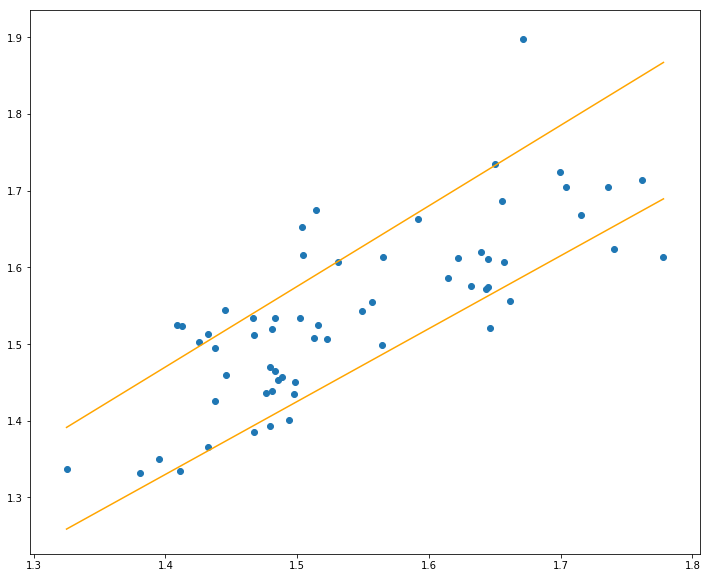

In [177]:
plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred)
ymin, ymax = min(y_test), max(y_test)
plt.plot([ymin,ymax], [ymin*1.05, ymax*1.05],color='orange')
plt.plot([ymin,ymax], [ymin*0.95, ymax*0.95],color='orange')

In [82]:
ymin, ymax

(0.5677, 0.7547)

In [109]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.01).fit(X_train, y_train)
krr.score(X_train, y_train)

-0.29039123717942616

In [5]:
MCIs = np.array([MolGraph(i).getMCI() for i in CH_data['SMILES']])

In [6]:
CH_data.loc[:,'MCI0'],CH_data.loc[:,'MCI1'], CH_data.loc[:,'vMCI0'], CH_data.loc[:,'vMCI1'] = MCIs[:,0],  MCIs[:,1],  MCIs[:,2],  MCIs[:,3]

In [7]:
Vm = np.array([Descriptors.MolWt(Chem.MolFromSmiles(i)) / j for i,j in zip(CH_data['SMILES'], CH_data['density(g/mL)']) ])

In [8]:
CH_data['Vm(mL/mol)'] = Vm

In [15]:
raw_data = np.array(CH_data.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1','T(K)','P(bar)')])

size = len(raw_data)
X_train = raw_data[:int(0.8*size)] #[:,(0,1,2,3)]
X_test = raw_data[int(0.8*size):] #[:,(0,1,2,3)]
y_train = CH_data['density(g/mL)'][:int(0.8*size)]
y_test = CH_data['density(g/mL)'][int(0.8*size):]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:870: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


In [10]:
CH_data.to_csv('data/result-CH-npt-MCI.csv')

In [127]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.7773664644215306

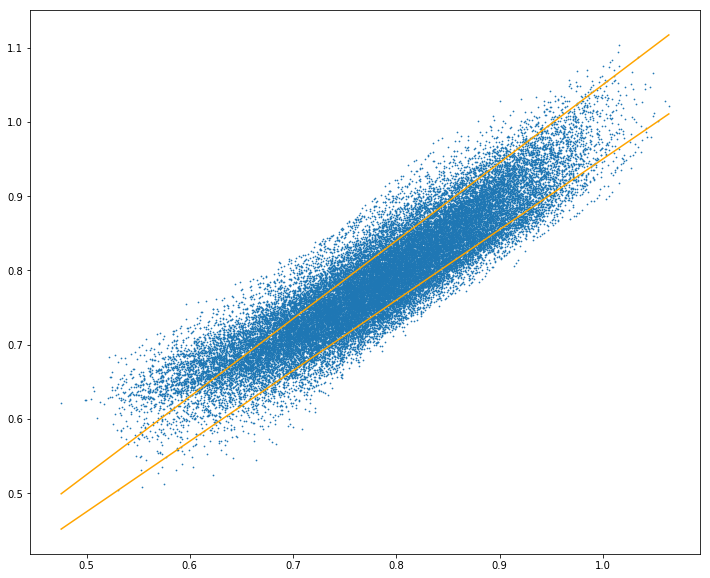

In [128]:
y_pred = reg.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred, s=0.5)
ymin, ymax = min(y_test), max(y_test)
plt.plot([ymin,ymax], [ymin*1.05, ymax*1.05],color='orange')
plt.plot([ymin,ymax], [ymin*0.95, ymax*0.95],color='orange')

In [28]:
MCIs = np.array(CH_data_TP.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1')])
size = len(MCIs)
ratio = 0.7
X_train = MCIs[:int(ratio*size)]#[:,(0,3)]
X_test = MCIs[int(ratio*size):]#[:,(0,3)]
y_train =  CH_data_TP['Vm(mL/mol)'][:int(ratio*size)] 
y_test =  CH_data_TP['Vm(mL/mol)'][int(ratio*size):]

In [18]:
from sklearn.linear_model import LinearRegression

In [38]:
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train, 100/y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))
y_pred = reg.predict(X_test)

0.8981499054069637
0.8340418134217478


In [20]:
import matplotlib.pyplot as plt

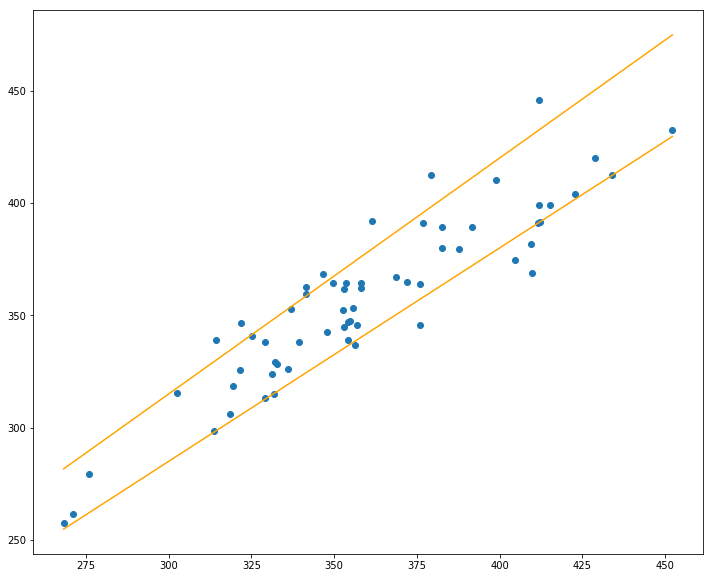

In [30]:
plt.figure(figsize=(12, 10))
plt.scatter(y_test, y_pred)
ymin, ymax = min(y_test), max(y_test)
plt.plot([ymin,ymax], [ymin*1.05, ymax*1.05],color='orange')
plt.plot([ymin,ymax], [ymin*0.95, ymax*0.95],color='orange')

In [27]:
CH_data_TP.head(10)

,SMILES,T(K),P(bar),density(g/mL),einter(kJ/mol),cp(J/mol.K),raw_density(g/mL),raw_einter(kJ/mol),MCI0,MCI1,vMCI0,vMCI1,Vm(mL/mol)
106013,C1CCCCC(C1)C1CCCCCC1,650,1,0.6232,-39.82,617.3,0.6190,-39.47,9.639982,6.966326,9.639982,6.966326,311.877407
106293,C1CCC2C(C1)CC1C(C2)CCCC1,650,1,0.6540,-39.76,583.7,0.6527,-39.56,9.380469,6.932653,9.380469,6.932653,294.107034
106626,C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1,650,1,0.6659,-39.11,579.0,0.6626,-38.89,9.380469,6.932653,9.380469,6.932653,288.851179
108185,C1CC[C@@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2,650,1,0.6657,-39.89,578.7,0.6629,-39.74,9.380469,6.949490,9.380469,6.949490,288.937960
108855,C1CC[C@H]2[C@@H](C1)C[C@@H]1[C@H](C2)CCCC1,650,1,0.6626,-38.89,585.3,0.6599,-38.66,9.380469,6.932653,9.380469,6.932653,290.289768
108910,C1CC[C@@H]2[C@@H](C1)C[C@@H]1[C@@H](C2)CCCC1,650,1,0.6563,-39.00,590.0,0.6507,-38.61,9.380469,6.932653,9.380469,6.932653,293.076337
109022,C1CC[C@H]2[C@@H](C1)[C@H]1CCCC[C@@H]1CC2,650,1,0.6665,-39.48,579.4,0.6653,-39.42,9.380469,6.949490,9.380469,6.949490,288.591148
109078,C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@H]1CC2,650,1,0.6619,-38.77,585.3,0.6583,-38.58,9.380469,6.949490,9.380469,6.949490,290.596767
109134,C1CC[C@@H]2[C@@H](C1)[C@@H]1CCCC[C@@H]1CC2,650,1,0.6612,-38.66,586.9,0.6565,-38.39,9.380469,6.949490,9.380469,6.949490,290.904416
110307,C1CCC(C1)C1CCC(C1)C1CCCC1,650,1,0.6518,-44.93,631.6,0.6496,-44.75,10.087576,7.432653,10.087576,7.432653,316.620129


# end2end test

In [1]:
% matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
import time
from matplotlib import pyplot as plt

In [2]:
# import data
CH_data = pd.read_csv(r"data/result-CH-npt-MCI.csv")
CH_data = CH_data.sample(frac=1,random_state=233)
CH_data.head(10)

,Unnamed: 0,SMILES,T(K),P(bar),density(g/mL),einter(kJ/mol),cp(J/mol.K),raw_density(g/mL),raw_einter(kJ/mol),MCI0,MCI1,vMCI0,vMCI1,Vm(mL/mol)
46040,46040,Cc1cc(C)c(cc1C)C,400,750,0.8544,-49.39,280.5,0.8549,-49.41,7.723615,4.609061,7.154701,3.654701,157.095037
108061,108061,CC(CCC(C1CCCCC1)(C)C)C,425,1000,0.8113,-59.88,474.1,0.8106,-59.80,10.604448,6.521674,10.604448,6.521674,242.053494
138068,138068,CC(C#C)CC,323,1,0.6803,-29.89,187.1,0.6797,-29.89,4.991564,2.808060,4.361807,2.270056,120.749669
31293,31293,CCC(CC(C(CC)C)(C)C)C,247,1,0.8042,-56.43,312.2,0.8049,-56.60,9.776021,5.435887,9.776021,5.435887,211.812982
63494,63494,C=CC(C)(C)C,212,50,0.7491,-31.36,159.6,0.7485,-31.32,5.207107,2.560660,4.784457,2.196923,112.350821
96395,96395,C1CC2C(C1)C1CCCC1CC2,614,750,0.7867,-43.54,452.9,0.7870,-43.53,7.966255,5.949490,7.966255,5.949490,208.836914
81549,81549,CCCCCCCCCCCCCC(=C)C,335,50,0.7674,-76.72,497.5,0.7667,-76.66,12.062632,7.770056,11.692388,7.414214,292.457649
45983,45983,Cc1cc(C)c(c(c1)C)C,543,500,0.7518,-41.20,337.0,0.7505,-41.10,7.723615,4.609061,7.154701,3.654701,178.534185
120834,120834,CCC1=CCCCCCC1,508,250,0.7169,-38.70,362.8,0.7167,-38.69,7.234205,4.931852,7.027098,4.611137,192.849770
12814,12814,CCCCC(CCCC)(C)C,314,50,0.7394,-49.81,340.0,0.7406,-49.91,8.742641,5.121320,8.742641,5.121320,211.405193


In [3]:
raw_data = np.array(CH_data.loc[:, ('MCI0', 'MCI1', 'vMCI0', 'vMCI1','T(K)','P(bar)')])

size = len(raw_data)
X_train = torch.Tensor(raw_data[:int(0.8*size)]) #[:,(0,1,2,3)]
X_test = torch.Tensor(raw_data[int(0.8*size):]) #[:,(0,1,2,3)]
y_train = torch.Tensor(np.array(CH_data['Vm(mL/mol)'][:int(0.8*size)]))
y_test = torch.Tensor(np.array(CH_data['Vm(mL/mol)'][int(0.8*size):]))

In [4]:
class Predictor(nn.Module):
    def __init__(self, feature_size, inner_layer = [64, 32, 16], dropout=0.5):
        super().__init__()
        self.layer = nn.ModuleList()
        first_layer = nn.Sequential(
            nn.Linear(feature_size, inner_layer[0]),
            nn.Dropout(dropout),
            # nn.BatchNorm1d(inner_layer[0]),
            # nn.ELU()
            nn.SELU(),
        )
        self.layer.append(first_layer)
        for i in range(len(inner_layer)-1):
            temp_layer = nn.Sequential(
                nn.Linear(inner_layer[i], inner_layer[i+1]),
                nn.Dropout(dropout),
                # nn.BatchNorm1d(inner_layer[i+1]),
                # nn.ELU()
                nn.SELU(),
            )
            self.layer.append(temp_layer)
        final_layer = nn.Sequential(
                nn.Linear(inner_layer[-1], 1, bias=False),
        )
        self.layer.append(final_layer)
    def forward(self, dense_input ):
        output = dense_input
        for layer in self.layer:
            output = layer(output)
        return output

In [6]:
class batch_generator():
    '''
    USAGE:  generator = batch_generator( batch_size = 50): 
            x_batch, y_batch = generator.next_batch(X_train, y_train)

    This function uses static method to count for next batch
    Note that caller is responsible to determine that how many rounds there should be in each epoch!
    For example:
        for epoch in range(total_epoch) :
            for small_round in range( len(y_train)/ self.batch_size )
                X_batch, y_batch = next_batch(X,y, self.batch_size)
                do something here
    '''
    def __init__(self,batch_size=100):
        self.batch_size = batch_size
        self.static_counter = 0
        self.new_round=False
        
    def next_batch(self, *args ):
        ''' should be same length for X and y '''
        if self.static_counter==None:
            self.static_counter = 0
        data_size = len(args[0])
        if ( self.static_counter+1 ) * self.batch_size >= data_size:
            self.static_counter = 0
            self.new_round = True
            return ( i[ data_size - self.batch_size: ] for i in args )
        else:
            self.static_counter += 1
            self.new_round = False
            start, end = self.batch_size * ( self.static_counter -1 ) , self.batch_size * self.static_counter
            return ( i[start:end] for i in args)

In [5]:
def stats(X, y, predictor):
    predictor.eval()
    MSE_f = nn.MSELoss()
    y_pred = predictor(X).view(-1)
    MSE = MSE_f(y_pred, y)
    relative_err = abs(y_pred - y) / y
    acc10 = (relative_err < 0.1).sum().item() / len(y)
    acc5 = (relative_err < 0.05).sum().item() / len(y)
    acc2 = (relative_err < 0.02).sum().item() / len(y)
    acc1 = (relative_err < 0.01).sum().item() / len(y)
    MRE = relative_err.sum() / len(y_test)
    
    # print("RMSE_norm:%.3f" % (MSE / y_std / y_std) )
    print("RMSE:%.6f" % (MSE**0.5) )
    print("MRE:%.3f%%" % (MRE*100))
    print("acc1: %d%% acc2: %d%% acc5: %d%% acc10: %d%% " % (acc1*100, acc2*100, acc5*100, acc10*100) )
    result = y_pred.detach().numpy()
    plt.figure(figsize=(7, 7))
    plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()],color='slategrey')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 0.95, y_test.max() * 0.95], color='orange')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 1.05, y_test.max() * 1.05], color='orange')
    plt.scatter( y_test, result, s=1 )
    plt.ylabel('predict '+ y_label, fontsize=16)
    plt.xlabel('actual ' + y_label, fontsize=16)
    plt.show()  

In [20]:
epoch_n = 5
batch_size = 200
lr = 0.0001
weight_decay = 0
data_feeder = batch_generator(batch_size)
predictor = Predictor(feature_size=6, dropout=0.5)
optimizer = torch.optim.RMSprop(predictor.parameters(), lr=lr, weight_decay=weight_decay)
MSE_f = nn.MSELoss()

In [21]:
for epoch in range(epoch_n):
    count = 0
    while True:
        count += 1
        X_batch, y_batch = data_feeder.next_batch(X_train, y_train)
        y_pred = predictor(X_batch).view(-1)
        loss = MSE_f(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        if data_feeder.new_round:
            break
        
        if count % 200 == 0:
            predictor.eval()
            y_test_pred = predictor(X_test).view(-1)
            val_loss = MSE_f(y_test_pred, y_test)
            # loss_total.append(val_loss.item())
            print("time:%s epoch:%d/%d(%d/%d) train_loss(std):%.4f val_loss(std):%.4f" % (time.ctime(), epoch+1 ,epoch_n, count * batch_size, len(y_train),  loss, val_loss))
            predictor.train()

time:Thu May 16 16:33:47 2019 epoch:1/5(40000/144878) train_loss(std):17273.4746 val_loss(std):6376.7139
time:Thu May 16 16:33:48 2019 epoch:1/5(80000/144878) train_loss(std):13277.6992 val_loss(std):5192.1274
time:Thu May 16 16:33:48 2019 epoch:1/5(120000/144878) train_loss(std):12496.9512 val_loss(std):7026.3350
time:Thu May 16 16:33:50 2019 epoch:2/5(40000/144878) train_loss(std):14159.5264 val_loss(std):5976.3633
time:Thu May 16 16:33:51 2019 epoch:2/5(80000/144878) train_loss(std):12846.5791 val_loss(std):5299.0391
time:Thu May 16 16:33:52 2019 epoch:2/5(120000/144878) train_loss(std):12893.2656 val_loss(std):4890.9346
time:Thu May 16 16:33:53 2019 epoch:3/5(40000/144878) train_loss(std):11860.6748 val_loss(std):5049.4858
time:Thu May 16 16:33:54 2019 epoch:3/5(80000/144878) train_loss(std):12918.3027 val_loss(std):4500.4087
time:Thu May 16 16:33:55 2019 epoch:3/5(120000/144878) train_loss(std):10514.4160 val_loss(std):3778.1140
time:Thu May 16 16:33:56 2019 epoch:4/5(40000/144878

In [17]:
y_batch

tensor([379.1081, 267.7206, 208.4813, 278.9715, 164.6638, 221.4747, 181.9747,
        101.4244, 252.2598, 156.0868, 231.8048, 133.1852, 206.1229, 190.8908,
        271.5351, 150.0888, 139.0617, 160.3689, 207.1876, 247.8140, 221.4654,
        336.8554, 153.5752, 204.5001, 236.4765, 215.7323, 177.2677, 360.8038,
        147.9846, 195.3281, 208.0410, 170.2177, 260.6460, 262.8036, 277.3844,
        117.4027, 251.9228, 225.4843, 222.3459, 239.7778, 257.7612, 185.0528,
        131.2122, 196.5276, 221.4305, 236.3208, 159.3284, 181.0714, 172.6562,
        280.5336, 236.1102, 218.4668, 281.1819, 212.0840, 124.3371, 182.8541,
        216.0213, 180.1076, 249.5135, 211.9184, 152.2017, 174.1283, 160.2046,
        223.1131, 116.6582, 175.4123, 208.8594, 156.5319, 255.0028, 193.2892,
        194.1789, 216.6349, 297.4246, 173.3810, 186.7822, 290.1530, 208.2142,
        202.7989, 197.5138, 339.2217, 217.5697, 307.9320, 195.7822, 174.8566,
        234.1765, 278.8802, 120.0614, 231.5661, 189.4985, 227.48

In [18]:
y_pred

tensor([348.0674, 241.9778, 207.8577, 250.3470, 150.4645, 258.7462, 203.4070,
        109.3234, 238.9664, 161.1006, 239.2092, 138.3448, 215.9293, 212.6802,
        315.9089, 152.5070, 161.3592, 176.3912, 208.6964, 233.5819, 210.5782,
        308.4825, 158.9103, 215.2167, 229.8705, 233.8080, 196.0804, 350.4515,
        170.1608, 169.6621, 214.5085, 162.4199, 273.9720, 269.1156, 273.9707,
        137.7379, 213.4136, 226.0486, 243.2332, 209.4829, 259.6536, 199.5422,
        151.1116, 200.5404, 232.5555, 223.3884, 159.6256, 170.7691, 173.3779,
        253.1542, 241.4522, 226.7564, 254.2227, 233.2336, 143.8946, 204.6262,
        212.1924, 199.6882, 279.3401, 205.4659, 170.4783, 166.4437, 186.0357,
        216.2714, 130.2246, 176.8643, 200.6899, 156.5082, 239.8490, 190.9016,
        171.0910, 209.6556, 263.3975, 194.5257, 197.2367, 283.5682, 241.0440,
        217.5133, 203.4504, 269.8954, 215.4985, 331.1570, 212.3156, 184.2204,
        243.7430, 250.5084, 124.6919, 242.3849, 210.4268, 218.39

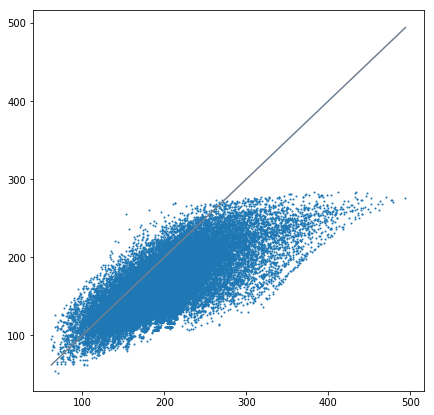

In [24]:
result = y_test_pred.detach().numpy()
plt.figure(figsize=(7, 7))
plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()],color='slategrey')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 0.95, y_test.max() * 0.95], color='orange')
    # plt.plot([y_test.min(),y_test.max()], [y_test.min() * 1.05, y_test.max() * 1.05], color='orange')
plt.scatter( y_test, result, s=1 )

In [6]:
data = pd.read_csv('data/result-CH-npt-MCI.csv')
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem

In [13]:
def C_num(smile):
    rdkmol =  Chem.MolFromSmiles(smile)
    count = 0
    for i in rdkmol.GetAtoms():
        if i.GetAtomicNum() == 6:
            count += 1
    return count

In [10]:
rdkmol = Chem.MolFromSmiles(data['SMILES'][233])

In [9]:
data['SMILES'][0]

'CCCC'

In [12]:
for i in rdkmol.GetAtoms():
    print(i.GetAtomicNum())

6
6
6
6
6


In [14]:
C_num_array = np.array([ C_num(i) for i in data['SMILES'] ])

In [15]:
data['C_num'] = C_num_array

In [16]:
data.head(10)

,Unnamed: 0,SMILES,T(K),P(bar),density(g/mL),einter(kJ/mol),cp(J/mol.K),raw_density(g/mL),raw_einter(kJ/mol),MCI0,MCI1,vMCI0,vMCI1,Vm(mL/mol),C_num
0,0,CCCC,160,1,0.7207,-26.27,112.4,0.7198,-26.22,3.414214,1.914214,3.414214,1.914214,80.649369,4
1,1,CCCC,186,1,0.6923,-24.83,114.8,0.6932,-24.88,3.414214,1.914214,3.414214,1.914214,83.957822,4
2,2,CCCC,211,1,0.6660,-23.52,118.7,0.6663,-23.52,3.414214,1.914214,3.414214,1.914214,87.273273,4
3,3,CCCC,237,1,0.6384,-22.18,124.5,0.6378,-22.15,3.414214,1.914214,3.414214,1.914214,91.046366,4
4,4,CCCC,263,1,0.6095,-20.84,132.0,0.6091,-20.82,3.414214,1.914214,3.414214,1.914214,95.363413,4
5,5,CCCC,289,1,0.5781,-19.46,141.1,0.5773,-19.44,3.414214,1.914214,3.414214,1.914214,100.543159,4
6,6,CCCC,314,1,0.5443,-18.04,151.3,0.5449,-18.06,3.414214,1.914214,3.414214,1.914214,106.786699,4
7,7,CCCC,340,1,0.5044,-16.45,163.5,0.5018,-16.37,3.414214,1.914214,3.414214,1.914214,115.233941,4
8,8,CCCC,160,50,0.7230,-26.37,111.6,0.7235,-26.41,3.414214,1.914214,3.414214,1.914214,80.392808,4
9,9,CCCC,186,50,0.6955,-24.96,114.3,0.6955,-24.97,3.414214,1.914214,3.414214,1.914214,83.571531,4


In [17]:
data.to_csv('data/result-CH-npt-MCI.csv')